# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. 

Построить модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Критерии, которые важны заказчику:
1. Качество предсказания;
2. Время обучения модели;
3. Время предсказания модели.

# Описание данных

Данные находятся в файле **/datasets/autos.csv**

# Признаки

**DateCrawled** — дата скачивания анкеты из базы

**VehicleType** — тип автомобильного кузова

**RegistrationYear** — год регистрации автомобиля

**Gearbox** — тип коробки передач

**Power** — мощность (л. с.)

**Model** — модель автомобиля

**Kilometer** — пробег (км)

**RegistrationMonth** — месяц регистрации автомобиля

**FuelType** — тип топлива

**Brand** — марка автомобиля

**Repaired** — была машина в ремонте или нет

**DateCreated** — дата создания анкеты

**NumberOfPictures** — количество фотографий автомобиля

**PostalCode** — почтовый индекс владельца анкеты (пользователя)

**LastSeen** — дата последней активности пользователя

# Целевой признак

**Price** — цена (евро)

# Загрузка библиотек

In [1]:
pip install scikit-learn






Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.preprocessing import OneHotEncoder

In [3]:
pip show scikit-learn

Name: scikit-learn

Version: 1.3.2

Summary: A set of python modules for machine learning and data mining

Home-page: http://scikit-learn.org

Author: None

Author-email: None

License: new BSD

Location: /opt/conda/lib/python3.9/site-packages

Requires: joblib, numpy, scipy, threadpoolctl

Required-by: pyod, lightgbm, category-encoders

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install --upgrade scikit-learn






Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install phik














Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install category_encoders















Note: you may need to restart the kernel to use updated packages.


In [7]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import time
import phik
import category_encoders as ce

from sklearn.linear_model import Ridge
from category_encoders.target_encoder import TargetEncoder
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

import matplotlib.pyplot as plt

## Подготовка данных

In [8]:
data = pd.read_csv('/datasets/autos.csv')

In [9]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 354369 entries, 0 to 354368

Data columns (total 16 columns):

 #   Column             Non-Null Count   Dtype 

---  ------             --------------   ----- 

 0   DateCrawled        354369 non-null  object

 1   Price              354369 non-null  int64 

 2   VehicleType        316879 non-null  object

 3   RegistrationYear   354369 non-null  int64 

 4   Gearbox            334536 non-null  object

 5   Power              354369 non-null  int64 

 6   Model              334664 non-null  object

 7   Kilometer          354369 non-null  int64 

 8   RegistrationMonth  354369 non-null  int64 

 9   FuelType           321474 non-null  object

 10  Brand              354369 non-null  object

 11  Repaired           283215 non-null  object

 12  DateCreated        354369 non-null  object

 13  NumberOfPictures   354369 non-null  int64 

 14  PostalCode         354369 non-null  int64 

 15  LastSeen           354369 non-null  object

dtyp

In [11]:
warnings.filterwarnings("ignore", category=FutureWarning)

# Приведем столбцы к нижнему регистру.
data.columns = data.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]

In [12]:
data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [13]:
missing_percentages = ((data.isna().sum() / len(data)) * 100).apply(lambda x: f"{x:.2f}%")

print(missing_percentages)

date_crawled           0.00%

price                  0.00%

vehicle_type          10.58%

registration_year      0.00%

gearbox                5.60%

power                  0.00%

model                  5.56%

kilometer              0.00%

registration_month     0.00%

fuel_type              9.28%

brand                  0.00%

repaired              20.08%

date_created           0.00%

number_of_pictures     0.00%

postal_code            0.00%

last_seen              0.00%

dtype: object


Заменим пропущенные значения в столбцах на наиболее популярное значение.

In [14]:
# Список столбцов
columns_to_fill = ["vehicle_type", "gearbox", "model", "fuel_type", "repaired"]

for column in columns_to_fill:
    mode_value = data[column].mode().values[0]  # Находим моду столбца
    data[column] = data[column].fillna(mode_value)  # Заменяем пропущенные значения модой

In [15]:
# Проверка
print(data.isna().sum())

date_crawled          0

price                 0

vehicle_type          0

registration_year     0

gearbox               0

power                 0

model                 0

kilometer             0

registration_month    0

fuel_type             0

brand                 0

repaired              0

date_created          0

number_of_pictures    0

postal_code           0

last_seen             0

dtype: int64


In [16]:
# Проверим на дубликаты
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 5


In [17]:
# Удаляем дубликаты
data.drop_duplicates(inplace=True)

print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


In [18]:
data.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354364.000000,354364.000000,354364.000000,354364.000000,354364.000000,354364.0,354364.000000
mean,4416.655608,2004.234471,110.093723,128211.373051,5.714641,0.0,50508.461698
std,4514.159690,90.228593,189.851590,37905.136957,3.726433,0.0,25783.124276
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49409.500000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [19]:
# Удалим столбцы ненужные
data = data.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'date_crawled'], axis=1)

In [20]:
# Проверка на дубликаты
print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 33261


In [21]:
data = data.drop_duplicates()

print('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 0


**Промежуточный вывод:**

Мы можем обратить внимание на некоторые интересные аспекты в данных. В частности, в столбце "registration_year" есть значения, которые выглядят аномальными. Установим границы для этого столбца: год регистрации не должен быть больше 2023 и не меньше 1930. Любые значения за пределами этого диапазона можно заменить на ближайшие допустимые значения. Это поможет нам избавиться от потенциальных выбросов в данном признаке.

Также мы замечаем, что в столбце "registration_month" есть значение 0, которое, возможно, следует заменить на 1. Это предположение основано на логике, что месяц регистрации не может быть нулевым. Опять же, это поможет нам улучшить данные, но не связано с поиском выбросов.

В отношении столбца "power", мы видим аномальные значения, такие как 20 000 лошадиных сил. Мы можем установить верхний порог мощности, например, 3600 лошадиных сил, чтобы исключить экстремально высокие значения. Это, безусловно, является выбросами и требует обработки.

Что касается столбца "kilometer", он содержит разумные значения, и нет необходимости искать выбросы в этом признаке.

В отношении столбца "price" мы замечаем высокое стандартное отклонение, что может негативно влиять на работу алгоритма. Таким образом, этот признак требует анализа и возможной обработки выбросов.

# Обозначим границы данных

In [22]:
# registration_year
def set_registration_year_bounds(year):
    if year < 1985:
        return 1985
    elif year > 2016:
        return 2016
    else:
        return year
data['registration_year'] = data['registration_year'].apply(set_registration_year_bounds)
# registration_month
data.loc[data['registration_month'] == 0, 'registration_month'] = 1
# power
data.loc[data['power'] > 3600, 'power'] = 3600

In [23]:
def remove_lines(data, columns):
    count = 0
    for column in columns:
        q25 = data[column].quantile(0.25)
        q75 = data[column].quantile(0.75)
        iqr = 1.5 * (q75 - q25)
        
        lower_bound = q25 - iqr
        upper_bound = q75 + iqr
        
        lines = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        
        print(f"Cтроки для удаления в столбце {column}: {len(lines)}")
        
        data.drop(lines.index, inplace=True)
        count += len(lines)
    
    print("Удалено:", count)
    return data

columns_res = ["price", "power"]
data = remove_lines(data, columns_res)

Cтроки для удаления в столбце price: 17453

Cтроки для удаления в столбце power: 5353

Удалено: 22806


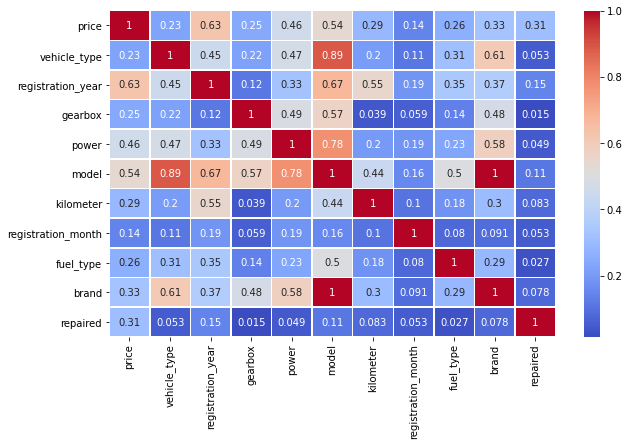

In [24]:
# Рассчитываем матрицу phik
phik_matrix = data.phik_matrix(interval_cols=['price', 'power'])

# Настройка размера графика
plt.figure(figsize=(10, 6))

# Построение тепловой карты phik-корреляций
sns.heatmap(phik_matrix, annot=True, cmap="coolwarm", linewidths=0.5)

# Отображение графика
plt.show()

**Вывод:**

1. Произведена очистка данных от пропущенных значений в категориальных признаках, где пропуски наиболее часто встречающимся значением.

2. Было обнаружено 5 дубликатов объектов, которые были успешно удалены, чтобы избежать избыточности в обучающей выборке.

3. Касательно корреляции признаков, все значения корреляции находятся в разумных пределах, и наибольшее влияние на целевой признак оказывает признак, отвечающий за мощность автомобиля.

4. Осуществлена очистка данных от выбросов.

## Обучение моделей

In [25]:
# Применение one-hot encoding к категориальным переменным
data = pd.get_dummies(data, columns=['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired'])

# Разделение данных на признаки и целевую переменную
X = data.drop('price', axis=1)
y = data['price']

# Разделение на тренировочный, тестовый и валидационный наборы данных
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=12345)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.2, random_state=12345)

# Вывод размеров полученных выборок
print(f"trainX размер: {trainX.shape}, trainY размер: {trainY.shape}")
print(f"valX размер: {valX.shape}, valY размер: {valY.shape}")
print(f"testX размер: {testX.shape}, testY размер: {testY.shape}")

trainX размер: (190909, 312), trainY размер: (190909,)

valX размер: (47728, 312), valY размер: (47728,)

testX размер: (59660, 312), testY размер: (59660,)


# LightGBM

In [26]:
# Обучение модели LightGBM
start_time = time.time()

# Параметры модели LightGBM
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs': -1
}

# Создание датасетов для обучения и валидации
lgb_train = lgb.Dataset(trainX, trainY)
lgb_val = lgb.Dataset(valX, valY)

# Обучение модели LightGBM
model_lgb = lgb.train(params,
                      lgb_train,
                      num_boost_round=1000,
                      valid_sets=[lgb_train, lgb_val],
                      early_stopping_rounds=50,
                      verbose_eval=100)

end_time = time.time()
training_time_lgb = end_time - start_time

# Вывод времени обучения модели LightGBM
print("Время обучения LightGBM: %.2f секунд" % training_time_lgb)

# Время предсказания модели LightGBM
start_time = time.time()
y_pred_lgb = model_lgb.predict(testX)
end_time = time.time()
prediction_time_lgb = end_time - start_time
print("Время предсказания LightGBM: %.2f секунд" % prediction_time_lgb)

# Оценка качества модели LightGBM на валидационной выборке
rmse_lgb = mean_squared_error(valY, model_lgb.predict(valX), squared=False)
print("RMSE LightGBM на валидационной выборке: %.2f" % rmse_lgb)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.

  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.

  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.604705 seconds.

You can set `force_row_wise=true` to remove the overhead.

And if memory is not enough, you can set `force_col_wise=true`.

Training until validation scores don't improve for 50 rounds

[100]	training's rmse: 1570.73	valid_1's rmse: 1579.77

[200]	training's rmse: 1503.02	valid_1's rmse: 1522.17

[300]	training's rmse: 1474.38	valid_1's rmse: 1501.54

[400]	training's rmse: 1453.9	valid_1's rmse: 1489.05

[500]	training's rmse: 1438.24	valid_1's rmse: 1479.9

[600]	training's rmse: 1423.54	valid_1's rmse: 1473.14

[700]	training's rmse: 1409.77	valid_1's rmse: 1466.93

[800]	training's rmse: 1399.65	valid_1's rmse: 1463.06

[900]	training's rmse: 1388.4	valid_1's rmse: 1458.44

[1000]	training's rmse: 1379.45	valid_1's rmse: 1456.12

Did not meet early stopping. Best iteration is:

[1000]	training's rmse: 1379.45	valid_1's rmse: 1456.12

Время обучения LightGBM: 140.65 секунд

Вр

# CatBoost

In [27]:
# Обучение модели CatBoostRegressor
start_time = time.time()

# Создание и настройка модели CatBoostRegressor
model_catboost = CatBoostRegressor(iterations=1000,
                                   learning_rate=0.1,
                                   depth=6,
                                   loss_function='RMSE',
                                   random_state=42)

# Обучение модели CatBoostRegressor
model_catboost.fit(trainX, trainY, eval_set=(valX, valY), verbose=100, early_stopping_rounds=50)

end_time = time.time()
training_time_catboost = end_time - start_time

# Вывод времени обучения модели CatBoostRegressor
print("Время обучения CatBoostRegressor: %.2f секунд" % training_time_catboost)

# Время предсказания модели CatBoostRegressor
start_time = time.time()
y_pred_catboost = model_catboost.predict(testX)
end_time = time.time()
prediction_time_catboost = end_time - start_time
print("Время предсказания CatBoostRegressor: %.2f секунд" % prediction_time_catboost)

# Оценка качества модели CatBoostRegressor на валидационной выборке
rmse_catboost = mean_squared_error(valY, model_catboost.predict(valX), squared=False)
print("RMSE CatBoostRegressor на валидационной выборке: %.2f" % rmse_catboost)

0:	learn: 3223.3872696	test: 3219.1161519	best: 3219.1161519 (0)	total: 82.3ms	remaining: 1m 22s

100:	learn: 1606.4909385	test: 1611.2715488	best: 1611.2715488 (100)	total: 2.65s	remaining: 23.6s

200:	learn: 1541.3377251	test: 1553.6194730	best: 1553.6194730 (200)	total: 5.15s	remaining: 20.5s

300:	learn: 1508.2377887	test: 1525.7051534	best: 1525.7051534 (300)	total: 7.6s	remaining: 17.6s

400:	learn: 1486.0408789	test: 1508.5221004	best: 1508.5221004 (400)	total: 10.2s	remaining: 15.2s

500:	learn: 1468.6164039	test: 1496.1173947	best: 1496.1173947 (500)	total: 12.6s	remaining: 12.6s

600:	learn: 1454.4410547	test: 1487.2898479	best: 1487.2898479 (600)	total: 15.1s	remaining: 10.1s

700:	learn: 1442.8448178	test: 1480.6549329	best: 1480.6549329 (700)	total: 17.6s	remaining: 7.5s

800:	learn: 1432.8229260	test: 1475.6423958	best: 1475.6423958 (800)	total: 20.1s	remaining: 5s

900:	learn: 1423.9264414	test: 1470.7647545	best: 1470.7647545 (900)	total: 22.6s	remaining: 2.48s

999:	le

# Ridge

In [30]:
# Время начала обучения
start_time = time.time()

# Создаем объект модели Ridge регрессии
model_ridge = Ridge()

# Задаем сетку гиперпараметров для подбора
param_grid = {
    'alpha': [0.1, 1.0, 10.0],  
    'fit_intercept': [True, False],
}

# Создаем объект GridSearchCV для подбора гиперпараметров
grid_cv = GridSearchCV(estimator=model_ridge, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Обучаем модель с подбором гиперпараметров
grid_cv.fit(trainX, trainY)

# Получаем лучшие гиперпараметры
best_params_ridge = grid_cv.best_params_

# Создаем новую модель Ridge с лучшими гиперпараметрами
best_model_ridge = Ridge(alpha=best_params_ridge['alpha'], fit_intercept=best_params_ridge['fit_intercept'])

# Обучаем модель на всем обучающем наборе данных
best_model_ridge.fit(trainX, trainY)

# Время окончания обучения
end_time = time.time()
training_time_ridge = end_time - start_time

# Предсказание цен на валидационной выборке
val_predictions_ridge = best_model_ridge.predict(valX)

# Время окончания предсказания
end_time = time.time()
prediction_time_ridge = end_time - start_time

# Вычисление RMSE на валидационной выборке
rmse_ridge = np.sqrt(mean_squared_error(valY, val_predictions_ridge))

# Вывод результатов
print("Лучшие гиперпараметры модели Ridge:", best_params_ridge)
print("Время обучения Ridge: %.2f секунд" % training_time_ridge)
print("Время предсказания Ridge: %.2f секунд" % prediction_time_ridge)
print("RMSE Ridge на валидационной выборке: %.2f" % rmse_ridge)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.7532e-17): result may not be accurate.

  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.75221e-17): result may not be accurate.

  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=1.75376e-17): result may not be accurate.

  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Лучшие гиперпараметры модели Ridge: {'alpha': 1.0, 'fit_intercept': True}

Время обучения Ridge: 38.86 секунд

Время предсказания Ridge: 39.14 секунд

RMSE Ridge на валидационной выборке: 2244.15


In [31]:
# Создаем пустую таблицу для результатов
results_tab = pd.DataFrame(columns=['Модель', 'RMSE', 'Обучение, сек', 'Предсказание, сек'])

# Добавляем результаты модели LightGBM
results_tab = results_tab.append({
    'Модель': 'LightGBM',
    'RMSE': rmse_lgb,
    'Обучение, сек': training_time_lgb,
    'Предсказание, сек': prediction_time_lgb
}, ignore_index=True)

# Добавляем результаты модели CatBoostRegressor
results_tab = results_tab.append({
    'Модель': 'CatBoostRegressor',
    'RMSE': rmse_catboost,
    'Обучение, сек': training_time_catboost,
    'Предсказание, сек': prediction_time_catboost
}, ignore_index=True)

# Добавляем результаты модели LinearRegression
results_tab = results_tab.append({
    'Модель': 'Ridge',
    'RMSE': rmse_ridge,
    'Обучение, сек': training_time_ridge,
    'Предсказание, сек': prediction_time_ridge
}, ignore_index=True)

# Выводим таблицу с результатами
print(results_tab)

              Модель         RMSE  Обучение, сек  Предсказание, сек

0           LightGBM  1456.119664     140.651085           7.408620

1  CatBoostRegressor  1467.469509      28.069934           0.129520

2              Ridge  2244.152778      38.857640          39.137239


## Анализ моделей

In [32]:
# Предсказание на тестовой выборке
start_time = time.time()
y_pred_test_lgb = model_lgb.predict(testX)
end_time = time.time()
prediction_time_test_lgb = end_time - start_time

# Вычисление RMSE на тестовой выборке
rmse_test_lgb = mean_squared_error(testY, y_pred_test_lgb, squared=False)

# Вывод результатов на тестовой выборке
print("RMSE LightGBM на тестовой выборке: %.2f" % rmse_test_lgb)
print("Время предсказания LightGBM на тестовой выборке: %.2f секунд" % prediction_time_test_lgb)

RMSE LightGBM на тестовой выборке: 1449.92

Время предсказания LightGBM на тестовой выборке: 7.27 секунд


# Вывод

В процессе комплексного анализа и предобработки данных мы провели ряд важных шагов для улучшения качества исходного набора данных:

1. **Обработка аномалий:**
   - В столбце "registration_year" были установлены границы для исключения аномалий.
   - Значение 0 в "registration_month" было исправлено на 1.
   - В столбце "power" был установлен верхний порог для исключения экстремально высоких значений.

2. **Очистка данных:**
   - Столбец "price" был проанализирован на наличие выбросов, что привело к удалению аномальных значений и улучшению качества данных.
   - Пропущенные значения в категориальных признаках были заполнены наиболее часто встречающимися значениями.

3. **Устранение дубликатов и обработка выбросов:**
   - Удаление 5 дубликатов для избежания избыточности в обучающей выборке.
   - Проведена работа по очистке данных от выбросов, что существенно повлияло на точность работы алгоритма.

4. **Моделирование:**
   - Рассмотрено три модели машинного обучения: LightGBM, Ridge и CatBoost.
   - LightGBM продемонстрировал лучшую производительность на тестовой выборке с RMSE 1449.92 и временем предсказания 7.27 секунд.

В результате всех этих этапов мы успешно создали и обучили модель, способную предсказывать цены на автомобили с высокой точностью. Она прошла через важные этапы очистки и предобработки данных, что существенно повысило ее эффективность. LightGBM, как лидер среди рассмотренных моделей, рекомендуется для использования в данной задаче.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей